In [1]:
from skimage.filters import gabor_kernel
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt 
import numpy as np

import math

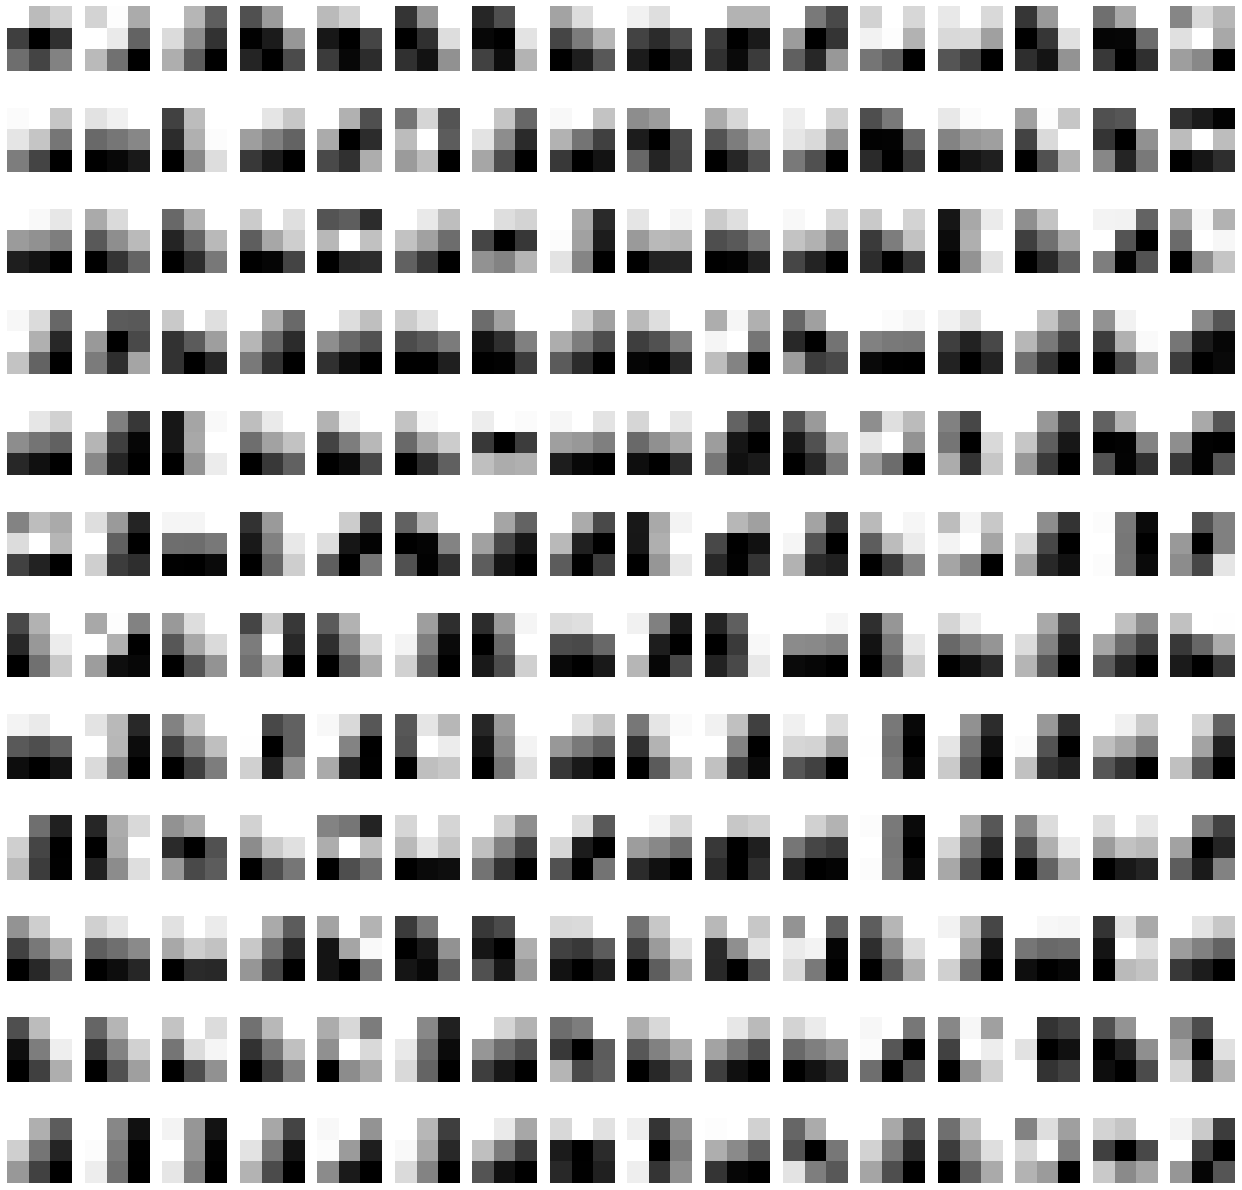

In [7]:
def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (1/4)*math.sqrt(2)**(-np.random.randint(0,8, (outchannels, inchannels)))
    thetas = (math.pi/39)*np.random.randint(0,39, (outchannels, inchannels))
    sigmas = 1/(2*freqs)
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
            g = g / (2 * math.pi * sigma ** 2)
            g = gabor_kernel(frequency=freq, bandwidth=sigma, theta=theta, offset=psi, n_stds=0).real
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, 64, (3,3))

fig = plt.subplots(12, 16, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(12, 16, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [8]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


In [9]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam

# dimensionality of input and latent encoded representations
inpt_dim = (32, 32, 3)

inpt_img = Input(shape=inpt_dim)

# Block 1
cl1 = Conv2D(64, (3, 3), strides=(2, 2),activation='relu', input_shape = inpt_dim)(inpt_img)
bnl2 = BatchNormalization()(cl1)
# afl3 = Activation('relu')(bnl2)
pl4 = MaxPooling2D(pool_size = (2, 2))(bnl2)

# Adding a second convolutional layer
cl5 = Conv2D(128, (3, 3), strides=(1, 1), activation='relu')(pl4)
bnl6 = BatchNormalization()(cl5)
# afl7 = Activation('relu')(bnl6)
pl8 = MaxPooling2D(pool_size = (2, 2))(bnl6)
bnl9 = BatchNormalization()(pl8)

# Step 3 - Flattening
fl10 = Flatten()(bnl9)

# Step 4 - Full connection
dol11 = Dropout(0.5)(fl10)
dl12 = Dense(units = 256, activation = 'relu')(dol11)
dol13 = Dropout(0.2)(dl12)
dl14 = Dense(units = 64, activation = 'relu')(dol13)
dol15 = Dropout(0.1)(dl14)
output = Dense(units = 10, activation = 'sigmoid')(dol15)

classifier = Model(inpt_img, output)

# Compiling the CNN
opt = RMSprop(learning_rate=0.001)
# opt = Adam(learning_rate=0.01)

classifier.compile(optimizer = opt, loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

print(classifier.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 128)        

In [10]:
cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

In [11]:
gabor_filters = np.empty(wshape, dtype='float32')
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index+channel_index]
# for k in range(0,wshape[3],3):
#   gabor_filters[:,:,0,k] = filterbank[k]
#   gabor_filters[:,:,1,k] = filterbank[k]
#   gabor_filters[:,:,2,k] = filterbank[k]


In [12]:
# Fitting the CNN to the images

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)

hist = classifier.fit(x_train, y_train, batch_size=100, epochs=1000, 
                   callbacks=[stop_alg, reduce_lr], shuffle=True, 
                   validation_data=(x_test, y_test))

classifier.save_weights("cnn.hdf5")


Epoch 1/1000
500/500 [==============================] - 43s 87ms/step - loss: 0.2639 - accuracy: 0.3924 - val_loss: 0.3072 - val_accuracy: 0.3017
Epoch 2/1000
500/500 [==============================] - 43s 86ms/step - loss: 0.2186 - accuracy: 0.5093 - val_loss: 0.2169 - val_accuracy: 0.5187
Epoch 3/1000
500/500 [==============================] - 44s 89ms/step - loss: 0.2033 - accuracy: 0.5510 - val_loss: 0.2420 - val_accuracy: 0.4468
Epoch 4/1000
500/500 [==============================] - 44s 88ms/step - loss: 0.1925 - accuracy: 0.5809 - val_loss: 0.1893 - val_accuracy: 0.5855
Epoch 5/1000
500/500 [==============================] - 47s 95ms/step - loss: 0.1853 - accuracy: 0.5985 - val_loss: 0.1910 - val_accuracy: 0.5773
Epoch 6/1000
500/500 [==============================] - 46s 92ms/step - loss: 0.1788 - accuracy: 0.6140 - val_loss: 0.1888 - val_accuracy: 0.5930
Epoch 7/1000
500/500 [==============================] - 49s 97ms/step - loss: 0.1738 - accuracy: 0.6258 - val_loss: 0.1888 -

500/500 [==============================] - 31s 62ms/step - loss: 0.0929 - accuracy: 0.8134 - val_loss: 0.1246 - val_accuracy: 0.7531
Epoch 107/1000
500/500 [==============================] - 26s 53ms/step - loss: 0.0921 - accuracy: 0.8166 - val_loss: 0.1244 - val_accuracy: 0.7552
Epoch 108/1000
500/500 [==============================] - 30s 59ms/step - loss: 0.0923 - accuracy: 0.8168 - val_loss: 0.1246 - val_accuracy: 0.7528
Epoch 109/1000
500/500 [==============================] - 30s 60ms/step - loss: 0.0929 - accuracy: 0.8137 - val_loss: 0.1243 - val_accuracy: 0.7530
Epoch 110/1000
500/500 [==============================] - 31s 63ms/step - loss: 0.0928 - accuracy: 0.8138 - val_loss: 0.1245 - val_accuracy: 0.7538
Epoch 111/1000
500/500 [==============================] - 27s 53ms/step - loss: 0.0926 - accuracy: 0.8146 - val_loss: 0.1243 - val_accuracy: 0.7516
Epoch 112/1000
500/500 [==============================] - 27s 54ms/step - loss: 0.0929 - accuracy: 0.8134 - val_loss: 0.1246 - 

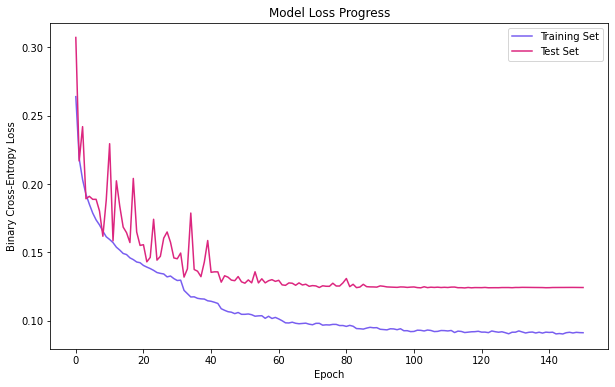

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cnn-gabor.cifar10.loss-5.png', dpi=350, bbox_inches='tight')
plt.show()

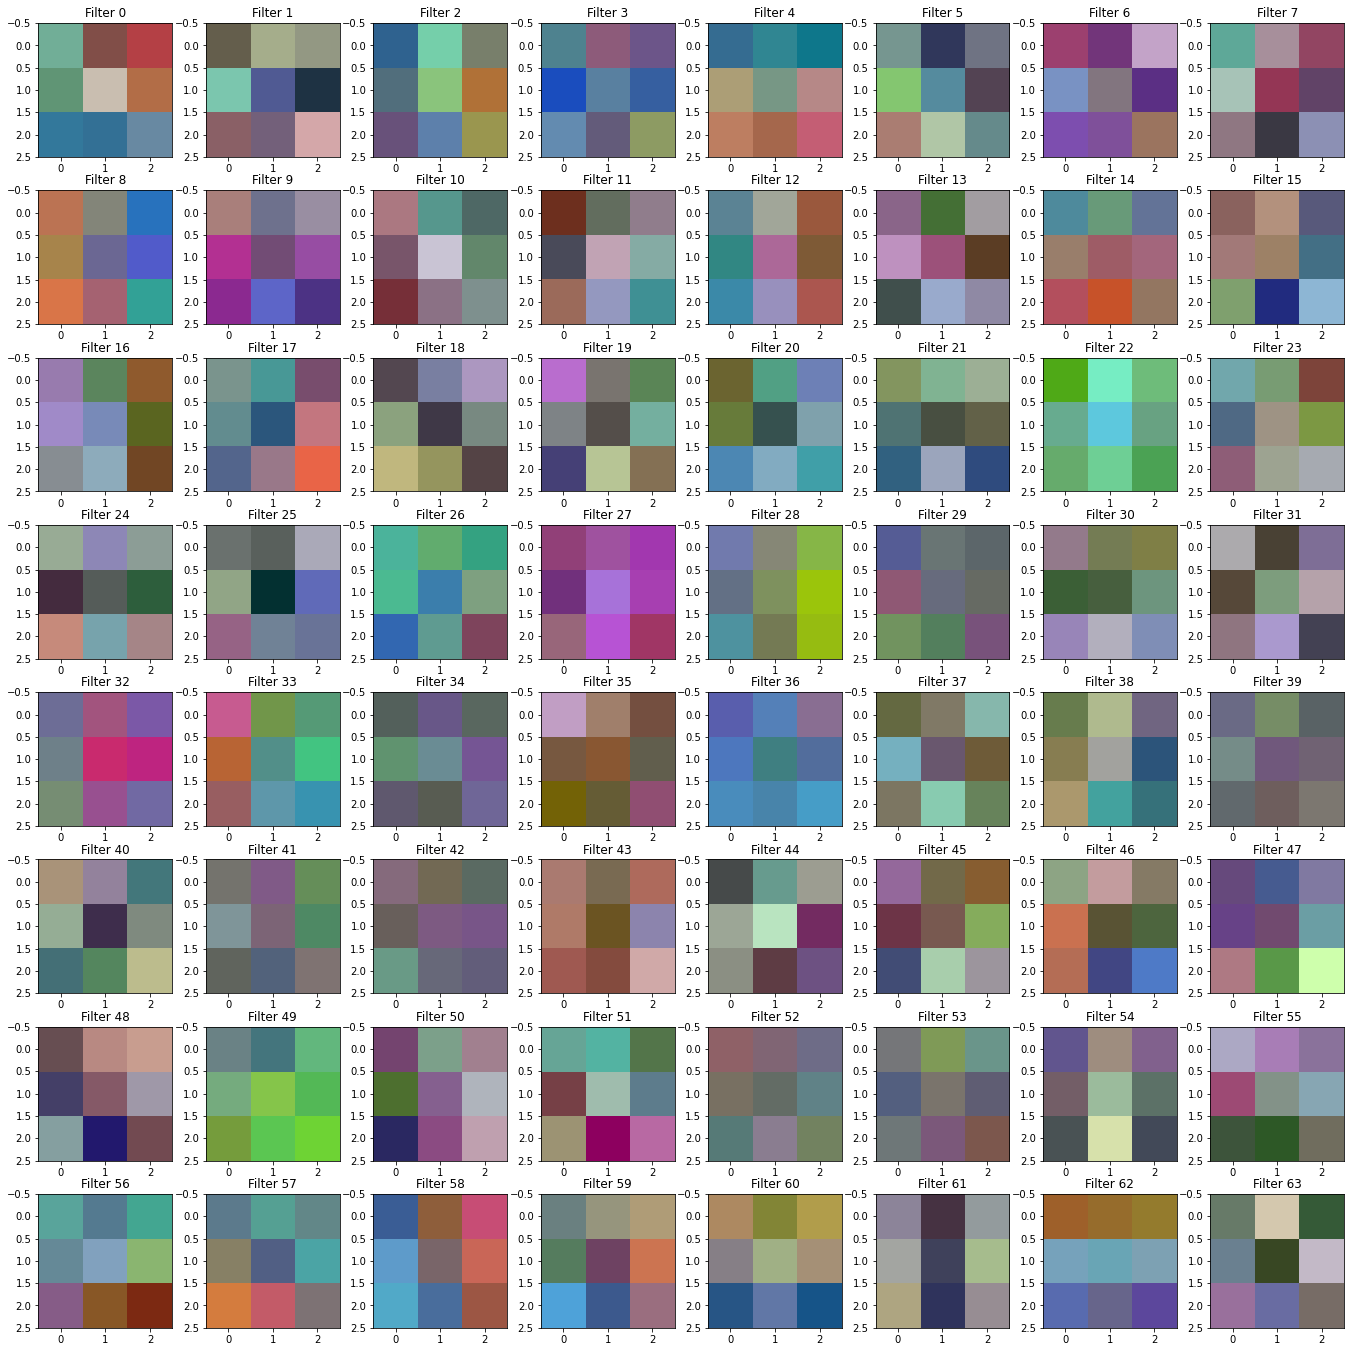

In [15]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

# since there are 64 filters, we will display them 8x8
fig, axs = plt.subplots(8,8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (3,3,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cnn-gabor.full.filters-5.png", bbox_inches='tight', dpi=350)

-0.3512438 0.36737472


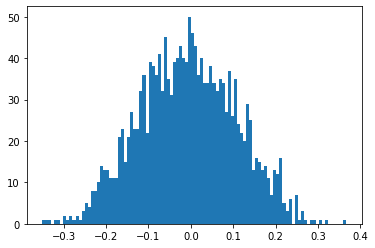

In [16]:
cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))